In [48]:
# Import modules
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import datetime
import csv
import requests
import pandas_datareader.data as web
import pandas_datareader as pdr
from pandas_datareader import data, wb

QUANDL_API_KEY= np.loadtxt('quandl_key.txt', dtype='str')

import quandl
quandl.ApiConfig.api_key = QUANDL_API_KEY
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.signal import detrend
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import fbprophet

%matplotlib inline
import seaborn as sns
#sns.set()
plt.style.use('seaborn')

In [49]:
def getstockdata(stock_name):
    stock_ind = stocks[stocks['Name'] == stock_name]
    y = stock_ind['y'].values
    return y 

def getstock(stock_name):
    stock_ind = stocks[stocks['Name'] == stock_name]
    return stock_ind

In [50]:
# Analyze stock data 
# based off of the following sources:
    # https://medium.com/@rohanjoseph_91119/stock-analysis-in-python-4e7b7884517a
    # https://www.learndatasci.com/tutorials/python-finance-part-yahoo-finance-api-pandas-matplotlib/

# define api key for quandl (in account settings)
#tickers = ['AAPL', 'MSFT', 'GOOGL', 'GM', 'TSLA', 'AMZN', 'KO', 'T', 'INTC', 'BMO', 'SLF', 'RY', 'CM'] # apple, microsoft
tickers = ['AAPL', 'MSFT', 'GOOGL']
scrape_method = 'tickers' # tickers or stock_list (full list)
start_date = '2011-01-01'
end_date = '2019-01-20'

# tickers: 
# '^GSPC', '^DJI', '^IXIC': S&P500, Dow Jones, Nasdaq

# get data

stocks = pd.DataFrame()
stock_names = []

if scrape_method == 'stock_list':
    sl = 10
elif scrape_method == 'tickers':
    sl = len(tickers)
    stock_list = tickers

for i in range(sl):
    print("Downloading data for", stock_list[i])
    if scrape_method == 'stock_list':
        stock = web.DataReader(stock_list[i],"quandl",start_date,end_date,access_key= QUANDL_API_KEY)
    elif scrape_method == 'tickers':
        stock = data.DataReader(stock_list[i], 'yahoo', start_date, end_date)
        #stock = quandl.get('WIKI/' + stock_list[i],start_date=start_date, end_date = end_date)
    
    stock_names.append(stock_list[i])
    stock['Name']=stock_list[i]
    ds = stock.index
    stocks = pd.DataFrame.append(stocks,stock)

stocks.reset_index(level=0, inplace = True)
stocks = stocks.rename(columns={'Date': 'ds', 'Adj Close': 'y'})

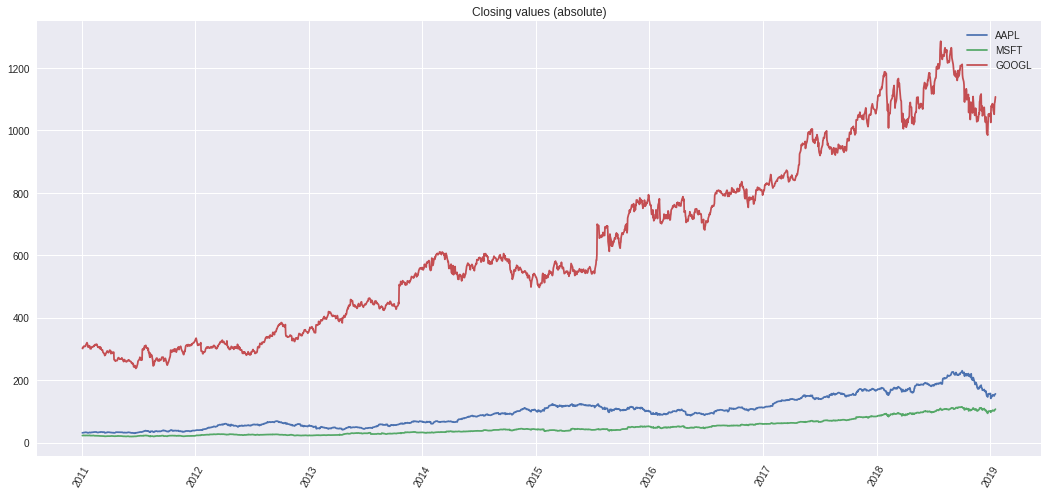

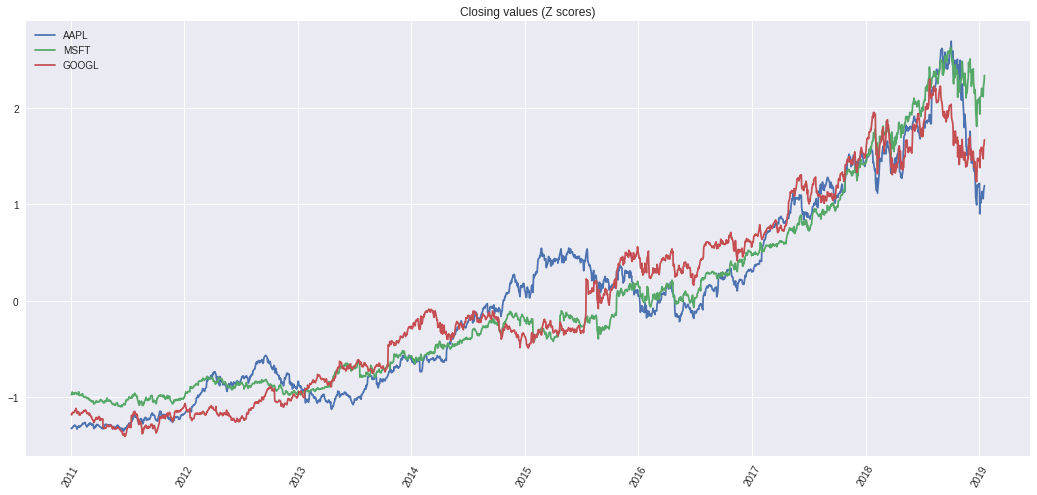

In [52]:
#Plot stock trends for selected stocks

# first plot raw data
plt.figure(figsize=(18,8)); 
leglabels = []
for i in range(len(stock_names)):
    stock_ind = stocks[stocks['Name'] == stock_names[i]]
    y = stock_ind['y']
    ds = stock_ind['ds']
    y_dt = detrend(y, axis=0, type='linear')
    plt.plot(ds, y)
    #plt.plot(np.array([y, y_dt]).T); #plt.legend(stock_names[i])
    plt.xticks(rotation=60)

plt.legend(stock_names)
plt.title('Closing values (absolute)')
plt.show()

# add 2nd plot with z-scores
plt.figure(figsize=(18,8)); 
for i in range(len(stock_names)):
    stock_ind = stocks[stocks['Name'] == stock_names[i]]
    y = stock_ind['y']
    ds = stock_ind['ds']
    y = zscore(y)
    # y = y - y[0] # subtract first value so that initial point is 0 for all stocks; easier to compare
    plt.plot(ds,y); #plt.legend(stock_names[i])
    plt.xticks(rotation=60)

plt.legend(stock_names)
plt.title('Closing values (Z scores)')
plt.show()

In [53]:
# modeling with Prophet!
stock = 'MSFT'
stock = getstock(stock)
stock_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
stock_prophet.fit(stock)

# Make a future dataframe for 2 years
stock_forecast_df = stock_prophet.make_future_dataframe(periods=365 * 2, freq='D')
# Make predictions
stock_forecast = stock_prophet.predict(stock_forecast_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


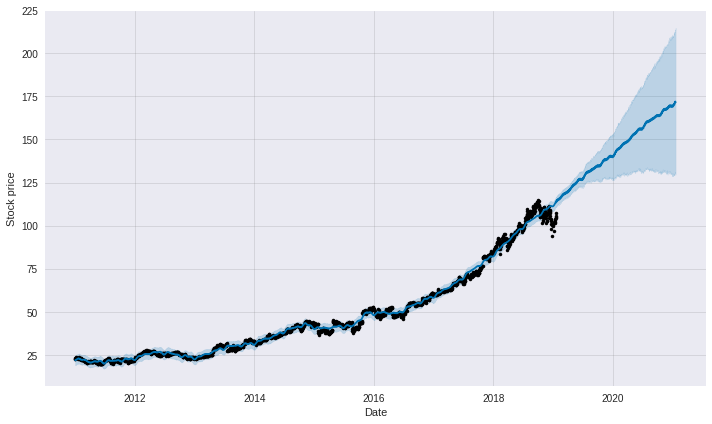

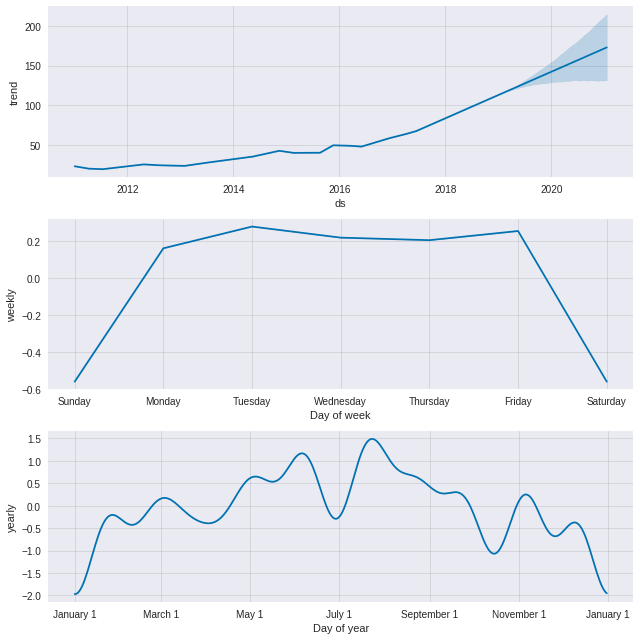

In [54]:
# plot things
stock_prophet.plot(stock_forecast, xlabel = 'Date', ylabel = 'Stock price')
# plt.title('Stock price: ' + stock);

stock_prophet.plot_components(stock_forecast);

# Extra stuff

In [ ]:
# Import list of stock names from NSE website
with requests.Session() as s:
    download = s.get('https://www.nseindia.com/products/content/sec_bhavdata_full.csv')
    decoded_content = download.content.decode('utf-8')
    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = pd.DataFrame(list(cr))
    
#View the top rows
#my_list.head()

# Clean the downloaded data
# Rename the headers
new_header = my_list.iloc[0] #grab the first row for the header
my_list = my_list[1:] #take the data less the header row
my_list = my_list.rename(columns = new_header)

# Get only the list of stock names - remove everything else
my_list['stock_name'] = "NSE/"+ my_list['SYMBOL']
stock_list = my_list['stock_name'].tolist()
stock_list = list(set(stock_list))
print(stock_list)


In [ ]:
# seasonal decompose

y = getstockdata('KO')
result = seasonal_decompose(y, model='additive', freq=1)
result.plot()
plt.show()

In [ ]:
# differencing

y = getstockdata('MSFT')
print(y)
diff = list()
for i in range(1, len(y)):
    value = y[i] - y[i - 1]
    diff.append(value)
plt.plot(diff)
plt.show()

In [ ]:
# detrending 

y = getstockdata('KO')
y_dt = detrend(y, 'linear',axis=0)
X = [i for i in range(0, len(y))]
X = numpy.reshape(X, (len(X), 1))
model = LinearRegression()
model.fit(X, y)

# calculate trend
trend = model.predict(X)
# plot trend
plt.plot(ds,y)
plt.plot(ds,trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(y))]

# plot detrended
plt.plot(ds,detrended)
plt.show()

In [46]:
detrend?